In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import jax
jax.config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import numpy.random as npr
from networks.dense import DenseNet
from networks.encoders import SigmaEncoder
from networks.decoders import SigmaDecoder
from models.SVAE_GMM import SVAE_GMM
from functools import partial
import flax.linen as nn
from networks.layers import LayerNorm
from tensorflow_probability.substrates.jax import distributions as tfd
import optax 
from train_utils import load_state, save_state, train_step, eval_step, create_dual_train_state, create_train_state

In [2]:
#Loading MNIST
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.ToTensor(),            
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [3]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

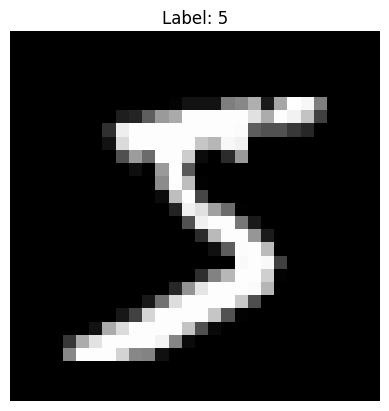

In [4]:
import matplotlib.pyplot as plt
flattened_img, label = train_dataset[0]

img_reshaped = flattened_img.view(28, 28)

plt.imshow(img_reshaped, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [5]:
cfg = lambda:0

# network hyperparameters
cfg.latent_D = 10
cfg.K = 10
cfg.encoder_stage_sizes = [1, 1, 1]
cfg.encoder_hidden_sizes = [500, 500, 2000]
cfg.decoder_stage_sizes = [1, 1, 1]
cfg.decoder_hidden_sizes = [2000, 500, 500]

# Define networks
encoder_network = partial(DenseNet, resnet=False, 
                          stage_sizes=cfg.encoder_stage_sizes, 
                          hidden_sizes=cfg.encoder_hidden_sizes,
                          activation=nn.gelu,
                          norm_cls=LayerNorm)

decoder_network = partial(DenseNet, resnet=False, 
                          stage_sizes=cfg.decoder_stage_sizes, 
                          hidden_sizes=cfg.decoder_hidden_sizes,
                          activation=nn.gelu,
                          norm_cls=LayerNorm)
                          
encoder = partial(SigmaEncoder, network_cls=encoder_network)
decoder = partial(SigmaDecoder, network_cls=decoder_network, likelihood=tfd.Normal)

# Creat model
model_builder = partial(SVAE_GMM, latent_D= cfg.latent_D, K = cfg.K, 
                        input_D = 784, encoder_cls=encoder, decoder_cls=decoder)

# Set optimization hyperparameters
cfg.lr_net = 1e-4
cfg.lr_pgm = 1e-3
#cfg.lr_decay_steps = 30000
#cfg.lr_final_mult = 0.01
cfg.learning_alg_pgm = 'sgd'
cfg.learning_alg_net = 'adam'
cfg.init_rng = jax.random.PRNGKey(47)
cfg.epochs = 1000

#net_schedule = optax.cosine_decay_schedule(cfg.lr_net, cfg.lr_decay_steps, cfg.lr_final_mult)
#pgm_schedule = optax.cosine_decay_schedule(cfg.lr_pgm, cfg.lr_decay_steps, cfg.lr_final_mult)
net_schedule = cfg.lr_net
pgm_schedule = cfg.lr_pgm
model, state = create_dual_train_state(cfg.init_rng, net_schedule, pgm_schedule, model_builder, (1,784), learning_alg_net=cfg.learning_alg_net, learning_alg_pgm=cfg.learning_alg_pgm)

... and the warmup model's architecture. Just as in the SLDS, we will pre-train with a VAE to get latent codes which contain *some* semantic information about the data before we start clustering. Training the SVAE-GMM from scratch has a much higher chance of collapsing to a small number of states.

In [6]:
#Setting Up VAE W/O GMM Prior
from models.VAE import VAE
from train_utils import create_train_state 

warmup_model_builder = partial(VAE, latent_D=cfg.latent_D, input_D=784,
                               encoder_cls=encoder, decoder_cls=decoder)
warmup_model, warmup_state = create_train_state(cfg.init_rng, cfg.lr_net, warmup_model_builder, (1,784))

In [7]:
#Beta Annealing
def get_beta_with_warmup(current_step):
    min_beta = 0.001
    warmup_steps = 5000
    total_annealing_steps = 14000
    
    if current_step < warmup_steps:
        return min_beta
    else:
        annealing_step = current_step - warmup_steps
        return min_beta + (1.0 - min_beta) * min(1.0, annealing_step / total_annealing_steps)

In [8]:
#Pre-Training
from tqdm import tqdm

num_epochs = 50

losses = []
total_steps = 0


for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)
    epoch_losses = []

    for batch in pbar:
        total_steps += 1

        batch = batch[0]

        batch_np = batch.detach().cpu().numpy()

        warmup_state, metrics = train_step(warmup_state, batch_np, N_data=len(train_loader.dataset), local_kl_weight=1e-3)

        epoch_losses.append(metrics['loss'])
        
        if np.isnan(metrics['loss'].item()):
            break
    
    loss = np.mean(epoch_losses)
    losses.append(loss)
    print(f"Epoch {epoch+1} | Epoch Loss: {loss:.4f}")

Epoch 1: 100%|██████████| 469/469 [00:26<00:00, 17.60it/s]


Epoch 1 | Epoch Loss: 1209.3752


Epoch 2: 100%|██████████| 469/469 [00:19<00:00, 24.38it/s]


Epoch 2 | Epoch Loss: 1213.0729


Epoch 3: 100%|██████████| 469/469 [00:23<00:00, 20.35it/s]


Epoch 3 | Epoch Loss: 1197.9808


Epoch 4: 100%|██████████| 469/469 [00:19<00:00, 23.56it/s]


Epoch 4 | Epoch Loss: 1189.3741


Epoch 5: 100%|██████████| 469/469 [00:18<00:00, 25.50it/s]


Epoch 5 | Epoch Loss: 1182.4264


Epoch 6: 100%|██████████| 469/469 [00:20<00:00, 23.28it/s]


Epoch 6 | Epoch Loss: 1173.4927


Epoch 7: 100%|██████████| 469/469 [00:18<00:00, 25.92it/s]


Epoch 7 | Epoch Loss: 1163.1375


Epoch 8: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]


Epoch 8 | Epoch Loss: 1149.8784


Epoch 9: 100%|██████████| 469/469 [00:21<00:00, 21.57it/s]


Epoch 9 | Epoch Loss: 1137.1581


Epoch 10: 100%|██████████| 469/469 [00:20<00:00, 23.32it/s]


Epoch 10 | Epoch Loss: 1122.2280


Epoch 11: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]


Epoch 11 | Epoch Loss: 1107.9153


Epoch 12: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]


Epoch 12 | Epoch Loss: 1092.2220


Epoch 13: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]


Epoch 13 | Epoch Loss: 1076.1733


Epoch 14: 100%|██████████| 469/469 [00:19<00:00, 24.68it/s]


Epoch 14 | Epoch Loss: 1060.0663


Epoch 15: 100%|██████████| 469/469 [00:19<00:00, 24.24it/s]


Epoch 15 | Epoch Loss: 1044.4229


Epoch 16: 100%|██████████| 469/469 [00:20<00:00, 22.90it/s]


Epoch 16 | Epoch Loss: 1026.7966


Epoch 17: 100%|██████████| 469/469 [00:18<00:00, 25.05it/s]


Epoch 17 | Epoch Loss: 1010.1175


Epoch 18: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]


Epoch 18 | Epoch Loss: 994.2709


Epoch 19: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]


Epoch 19 | Epoch Loss: 975.8530


Epoch 20: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]


Epoch 20 | Epoch Loss: 958.4968


Epoch 21: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]


Epoch 21 | Epoch Loss: 941.8282


Epoch 22: 100%|██████████| 469/469 [00:19<00:00, 24.30it/s]


Epoch 22 | Epoch Loss: 923.8530


Epoch 23: 100%|██████████| 469/469 [00:19<00:00, 24.48it/s]


Epoch 23 | Epoch Loss: 905.7950


Epoch 24: 100%|██████████| 469/469 [00:20<00:00, 23.10it/s]


Epoch 24 | Epoch Loss: 888.7848


Epoch 25: 100%|██████████| 469/469 [00:19<00:00, 23.63it/s]


Epoch 25 | Epoch Loss: 869.3138


Epoch 26: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]


Epoch 26 | Epoch Loss: 852.0532


Epoch 27: 100%|██████████| 469/469 [00:20<00:00, 23.07it/s]


Epoch 27 | Epoch Loss: 834.8663


Epoch 28: 100%|██████████| 469/469 [00:20<00:00, 22.66it/s]


Epoch 28 | Epoch Loss: 817.1164


Epoch 29: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]


Epoch 29 | Epoch Loss: 799.2324


Epoch 30: 100%|██████████| 469/469 [00:19<00:00, 24.26it/s]


Epoch 30 | Epoch Loss: 781.0435


Epoch 31: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]


Epoch 31 | Epoch Loss: 763.3907


Epoch 32: 100%|██████████| 469/469 [00:20<00:00, 23.25it/s]


Epoch 32 | Epoch Loss: 746.2557


Epoch 33: 100%|██████████| 469/469 [00:19<00:00, 23.51it/s]


Epoch 33 | Epoch Loss: 730.1337


Epoch 34: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]


Epoch 34 | Epoch Loss: 711.5958


Epoch 35: 100%|██████████| 469/469 [00:19<00:00, 23.67it/s]


Epoch 35 | Epoch Loss: 693.3064


Epoch 36: 100%|██████████| 469/469 [00:22<00:00, 20.93it/s]


Epoch 36 | Epoch Loss: 675.4250


Epoch 37: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]


Epoch 37 | Epoch Loss: 659.6154


Epoch 38: 100%|██████████| 469/469 [00:17<00:00, 26.49it/s]


Epoch 38 | Epoch Loss: 643.8284


Epoch 39: 100%|██████████| 469/469 [00:18<00:00, 25.29it/s]


Epoch 39 | Epoch Loss: 626.0546


Epoch 40: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]


Epoch 40 | Epoch Loss: 610.0485


Epoch 41: 100%|██████████| 469/469 [00:20<00:00, 22.72it/s]


Epoch 41 | Epoch Loss: 594.3044


Epoch 42: 100%|██████████| 469/469 [00:20<00:00, 22.99it/s]


Epoch 42 | Epoch Loss: 577.9383


Epoch 43: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s]


Epoch 43 | Epoch Loss: 561.2261


Epoch 44: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


Epoch 44 | Epoch Loss: 546.8961


Epoch 45: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]


Epoch 45 | Epoch Loss: 531.0000


Epoch 46: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]


Epoch 46 | Epoch Loss: 516.4225


Epoch 47: 100%|██████████| 469/469 [00:18<00:00, 24.78it/s]


Epoch 47 | Epoch Loss: 500.4799


Epoch 48: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]


Epoch 48 | Epoch Loss: 486.4494


Epoch 49: 100%|██████████| 469/469 [00:18<00:00, 25.60it/s]


Epoch 49 | Epoch Loss: 470.8053


Epoch 50: 100%|██████████| 469/469 [00:18<00:00, 25.89it/s]

Epoch 50 | Epoch Loss: 456.3166


As with the SLDS, we do not pre-train until convergence; doing so might make the clusters highly non-Gaussian in the latent space, and that local optimum for the encoder/decoder is difficult to escape from.

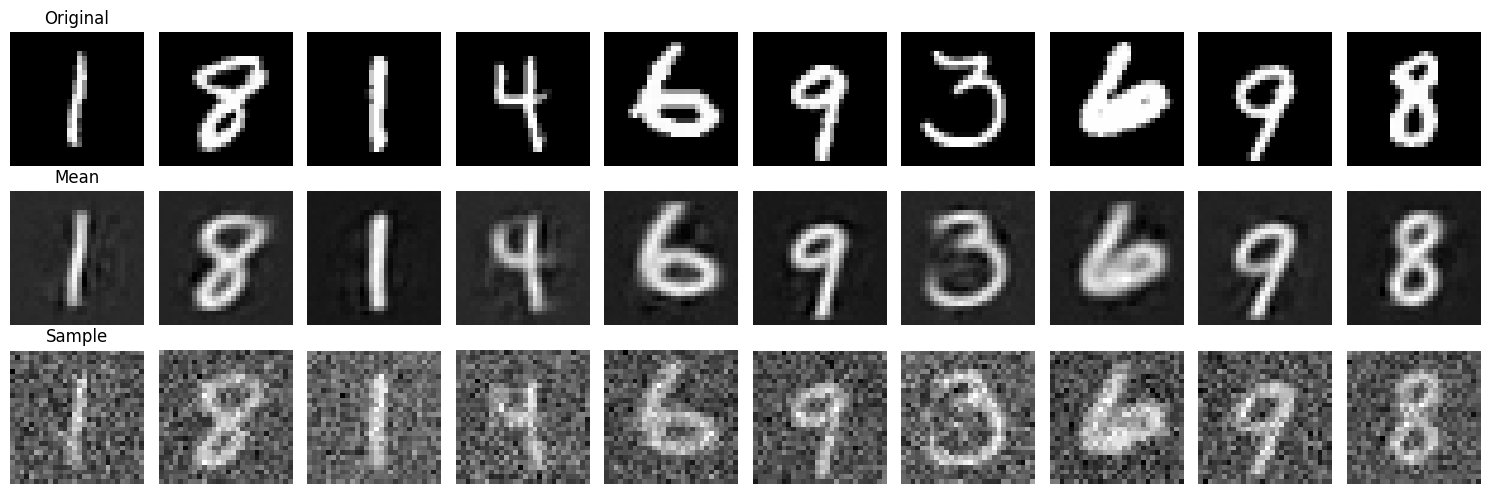

In [9]:
import matplotlib.pyplot as plt
import jax.random

batch, _ = next(iter(train_loader))
batch = batch.numpy()
batch = jnp.array(batch)

_, _, likelihood, aux = eval_step(warmup_state, batch, N_data=60000)

recon_means = likelihood.mean()  
recon_samples = likelihood.sample(seed=jax.random.PRNGKey(0))

fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i in range(10):
    # Original
    axes[0, i].imshow(batch[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0: axes[0, i].set_title("Original")

    # Mean reconstruction
    axes[1, i].imshow(recon_means[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0: axes[1, i].set_title("Mean")

    # Sampled reconstruction
    axes[2, i].imshow(recon_samples[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    if i == 0: axes[2, i].set_title("Sample")

plt.tight_layout()
plt.show()

In [10]:
#Latent assignments
all_latents_train = []

train_loader_inference = DataLoader(train_dataset, batch_size=128, shuffle=False)
true_labels_train = train_dataset.targets.numpy()

for batch in train_loader_inference:
    batch = batch[0]
    batch_np = batch.detach().cpu().numpy()
    _, _, _, aux = eval_step(warmup_state, batch_np, N_data=len(train_loader_inference.dataset))
    z = aux['aux'].mean()
    all_latents_train.append(z)
    
all_latents_train_np = np.concatenate(all_latents_train, axis=0)

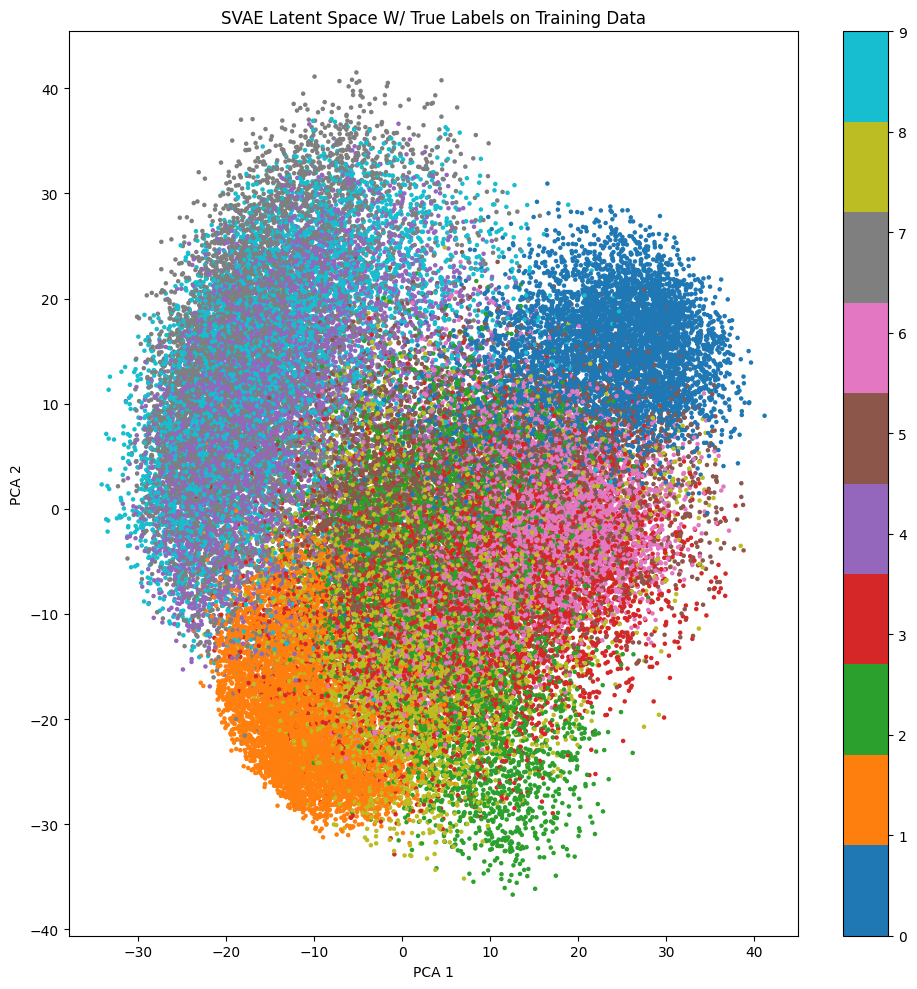

In [11]:
from sklearn.decomposition import PCA
z_pca = PCA(n_components=2).fit_transform(all_latents_train_np)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=true_labels_train, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title("SVAE Latent Space W/ True Labels on Training Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

In [12]:
#Initializing full model with pretrained VAE parameters
new_params = state.params.copy()
new_params['encoder'] = warmup_state.params['encoder']
new_params['decoder'] = warmup_state.params['decoder']
state = state.replace(params=new_params)

In [13]:
import pandas as pd

df = pd.DataFrame(all_latents_train_np)
df.to_csv('latent_vectors.csv', index=False, header=False)

In [14]:
#Initializing Cluster Means With BNPY
import bnpy
from bnpy.data import GroupXData

X = np.loadtxt('latent_vectors.csv', delimiter=',')
N = X.shape[0]
Data = GroupXData(X=X, doc_range=np.array([0, N]))

hmodel, info_dict = bnpy.run(Data,
         'FiniteMixtureModel', 'Gauss', 'memoVB',
         K=10, nLap=1000, convergeThr=0.0001,
         output_path='initialization/')

Dataset Summary:
GroupXData
  total size: 1 units
  batch size: 1 units
  num. batches: 1
Allocation Model:  Finite mixture model. Dir prior param 1.00
Obs. Data  Model:  Gaussian with full covariance.
Obs. Data  Prior:  Gauss-Wishart on mean and covar of each cluster
  E[  mean[k] ] = 
   [0. 0.]  ...
  E[ covar[k] ] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 10 (number of clusters)
  seed = 1607680
  elapsed_time: 0.1 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: initialization/1
    1.000/1000 after      0 sec. |    671.1 MiB | K   10 | loss  3.865811019e+00 |  
    2.000/1000 after      0 sec. |    683.1 MiB | K   10 | loss  3.798215196e+00 | Ndiff  553.240 
    3.000/1000 after      0 sec. |    661.2 MiB | K   10 | loss  3.775926853e+00 | Ndiff  577.872 
    4.000/1000 after      1 sec. |    669.1 MiB | K   10 | loss  3.762448488e+00 | Ndiff  433.504 
    5.000/1000 after      1 sec. |    640.

In [15]:
import jax.numpy as jnp
from flax.core import freeze, unfreeze

means_fn = hmodel.obsModel.get_mean_for_comp
means_np = np.array([means_fn(k) for k in range(hmodel.obsModel.K)])

means_jax = jnp.array(means_np)[:, :, jnp.newaxis]

In [16]:
new_params = state.params.copy()
new_params['pgm']['loc'] = means_jax
state = state.replace(params=new_params)

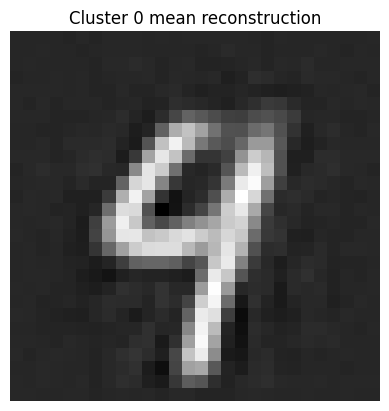

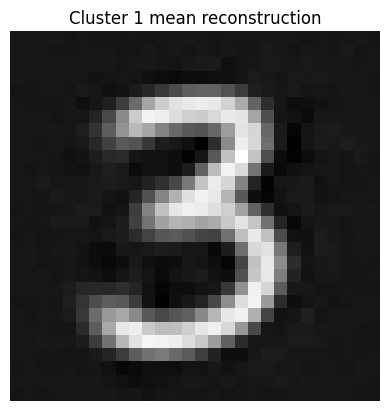

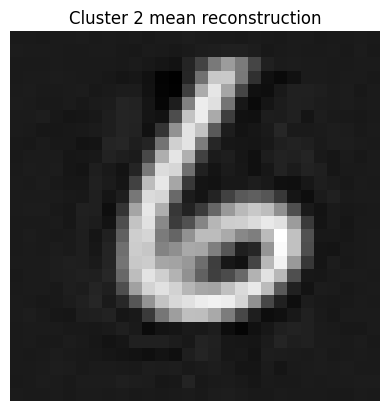

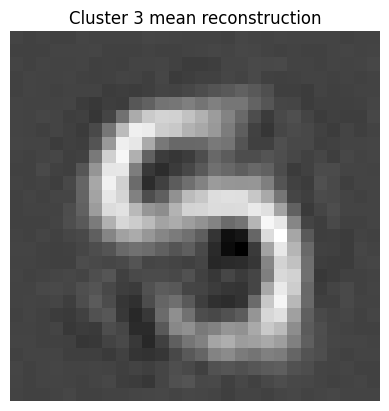

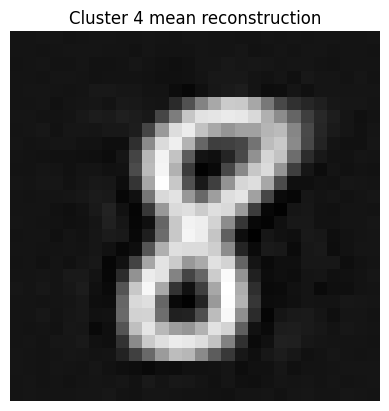

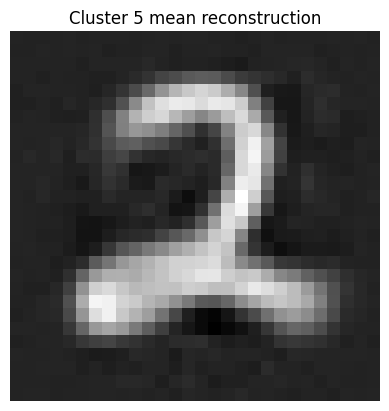

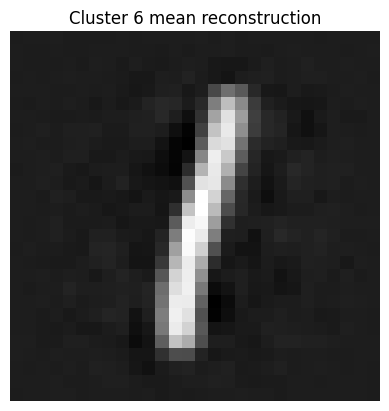

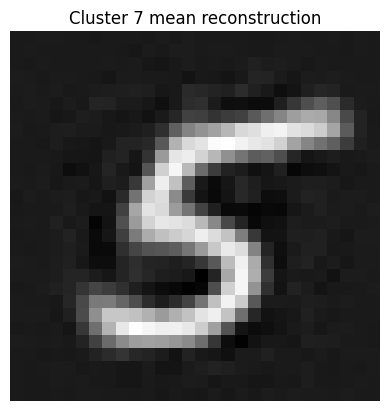

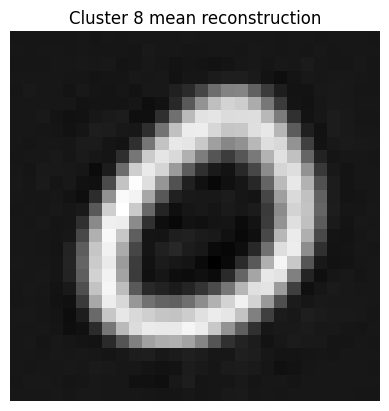

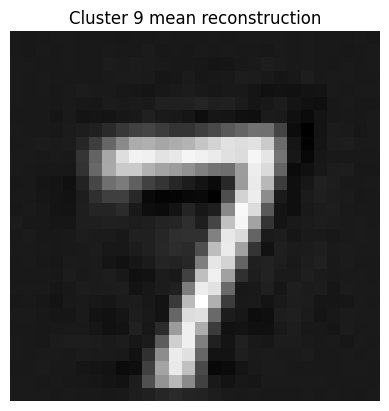

In [17]:
for k in range(10):
    mu_k = state.params['pgm']['loc'][k]
    z = mu_k.T.astype(jnp.float32)

    likelihood = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        z,
        method=SVAE_GMM.decode
    )

    recon_img = likelihood.mean()[0]
    plt.imshow(recon_img.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'Cluster {k} mean reconstruction')
    plt.show()

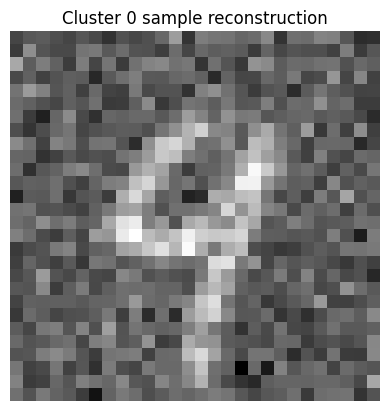

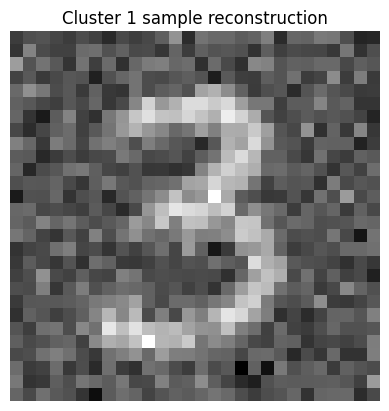

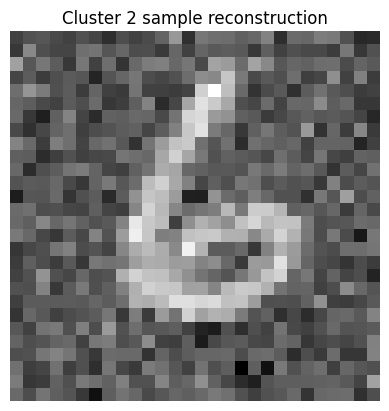

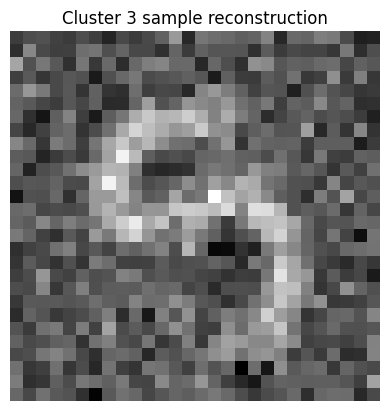

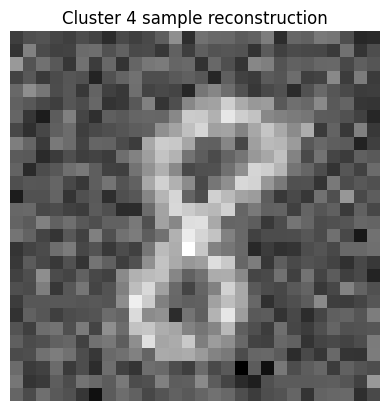

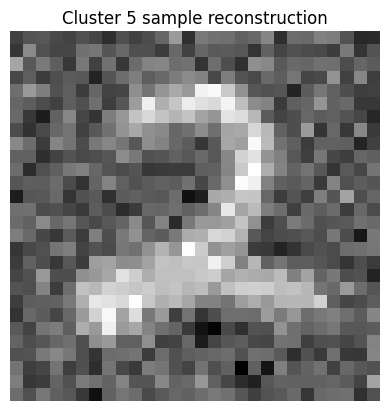

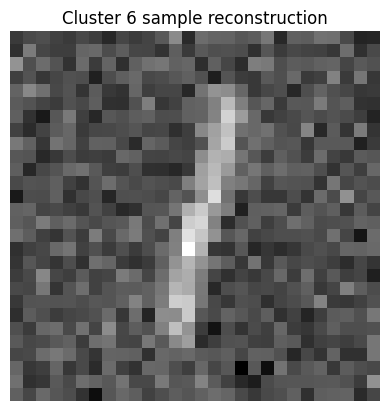

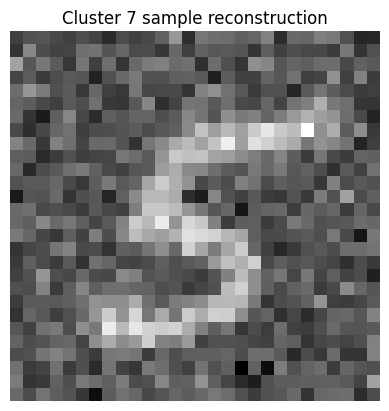

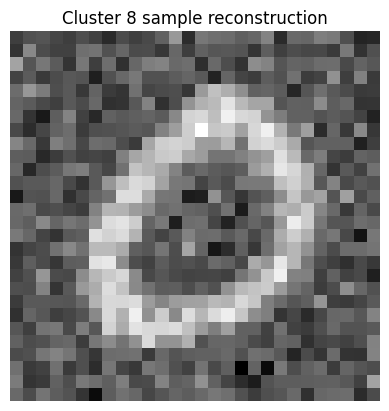

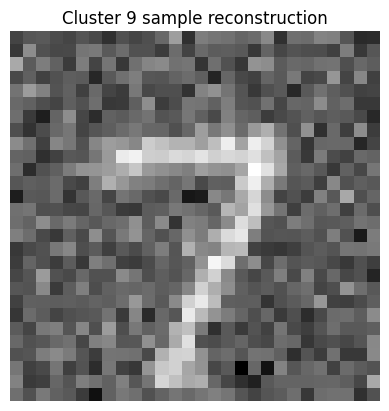

In [18]:
for k in range(10):
    mu_k = state.params['pgm']['loc'][k]
    z = mu_k.T.astype(jnp.float32)

    likelihood = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        z,
        method=SVAE_GMM.decode
    )

    recon_img = likelihood.sample(seed=jax.random.PRNGKey(47))
    plt.imshow(recon_img.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'Cluster {k} sample reconstruction')
    plt.show()

In [19]:
#Latent and cluster assignments
all_latents_train = []
all_clusters_train = []

for batch in train_loader_inference:
    batch = batch[0]
    batch_np = batch.detach().cpu().numpy()

    _, _, _, aux = eval_step(state, batch_np, N_data=len(train_loader_inference.dataset))
    
    z = aux['aux'][0] 
    c = aux['aux'][1]

    all_latents_train.append(z)
    all_clusters_train.append(jnp.argmax(c, axis=1))
    
all_latents_train_np = jnp.concatenate(all_latents_train, axis=0)
all_clusters_train_np = jnp.concatenate(all_clusters_train, axis=0)

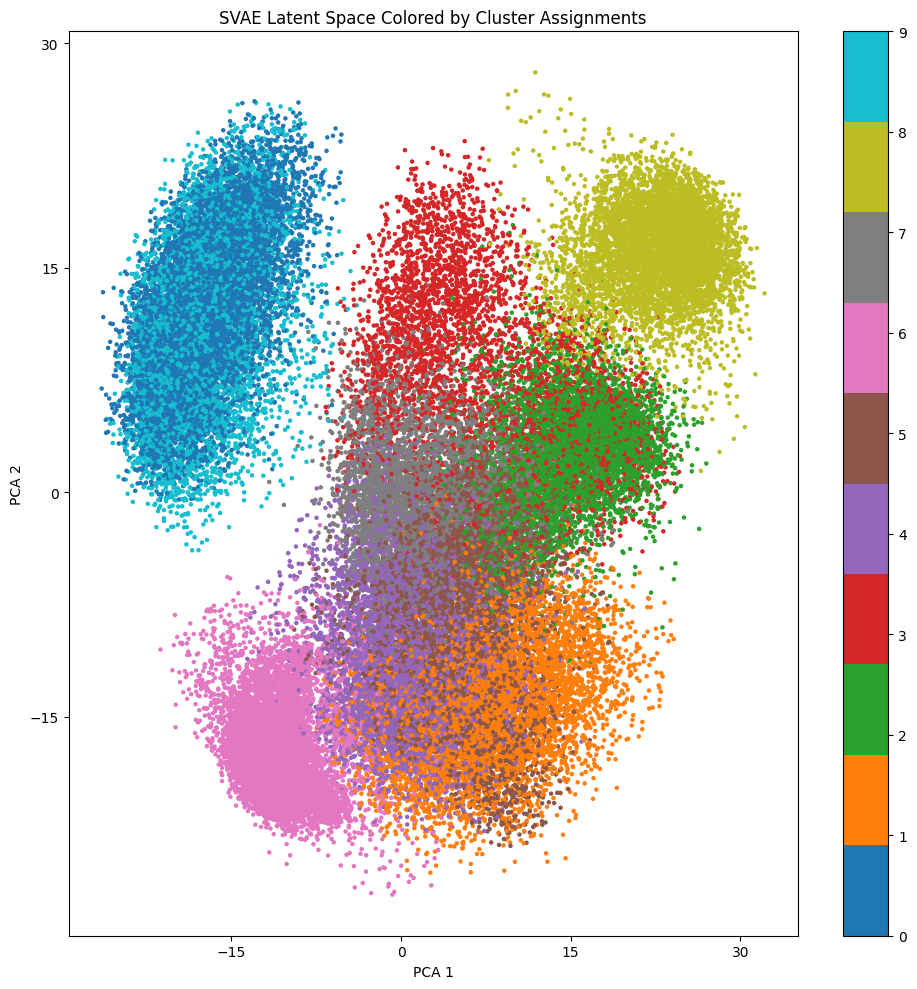

In [20]:
from sklearn.decomposition import PCA
z_pca = PCA(n_components=2).fit_transform(all_latents_train_np)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=all_clusters_train_np, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title("SVAE Latent Space Colored by Cluster Assignments")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

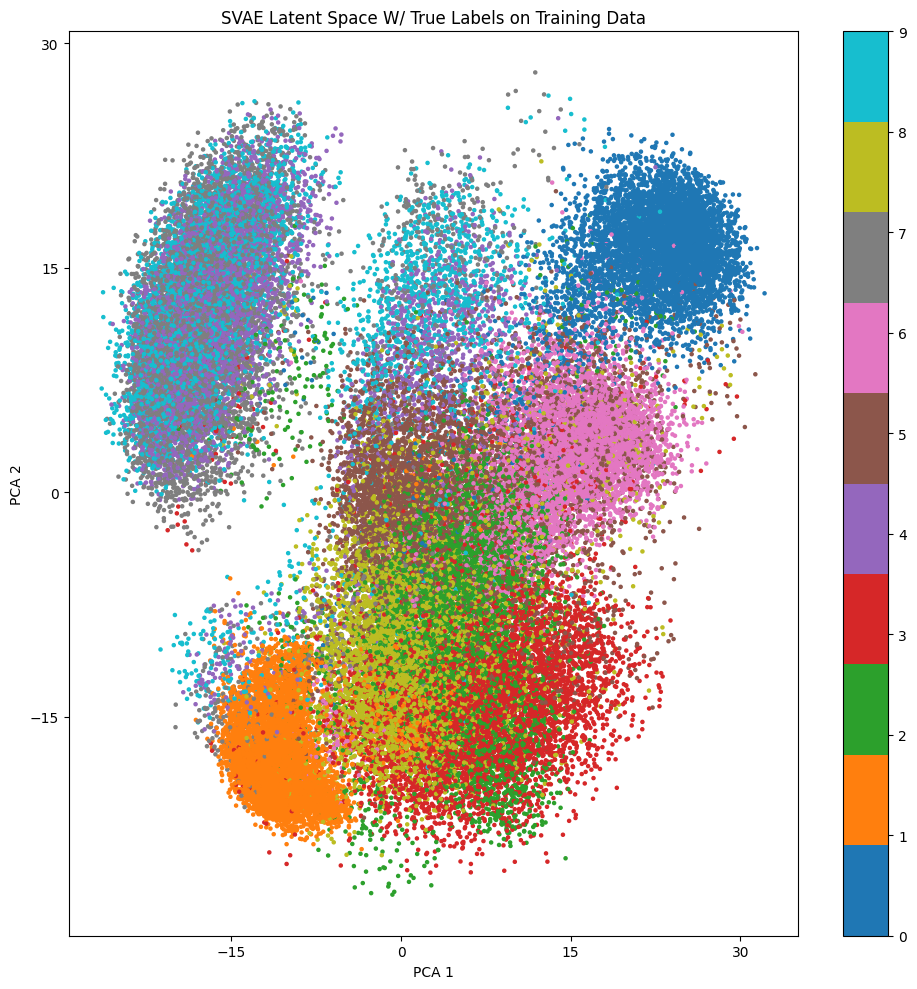

In [21]:
z_pca = PCA(n_components=2).fit_transform(all_latents_train_np)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=true_labels_train, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title("SVAE Latent Space W/ True Labels on Training Data")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

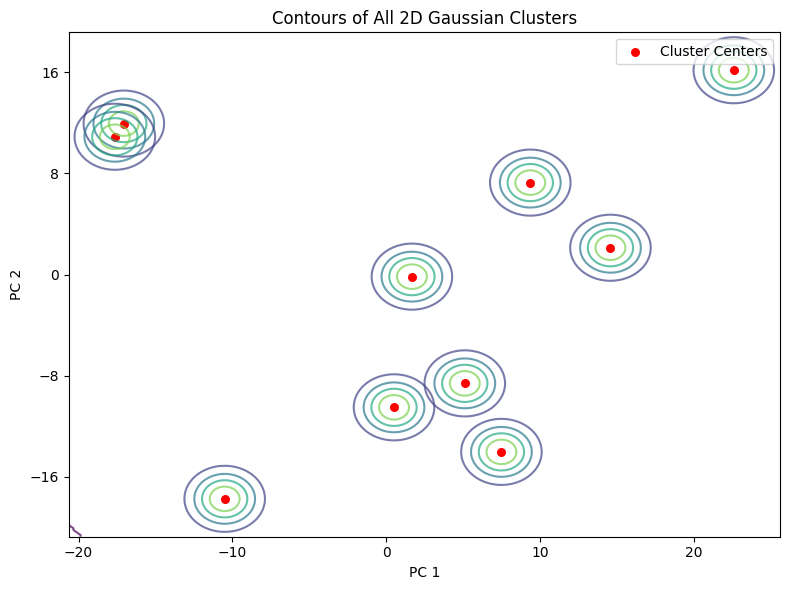

In [22]:
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

# Extract cluster parameters from your model
S = state.params['pgm']['S']         # shape: (K, D, D)
nu = state.params['pgm']['nu']       # shape: (K,)
loc = state.params['pgm']['loc']     # shape: (K, D)

# Convert from JAX to NumPy and squeeze
means = [np.array(loc[k]).squeeze() for k in range(len(loc))]
D = S.shape[-1]
covariances = [np.array(S[k]) for k in range(len(S))]

# Project to 2D using PCA (fit on means)
means_matrix = np.stack(means)  # shape: (K, D)
pca = PCA(n_components=2)
pca.fit(all_latents_train_np)
means_2d = pca.transform(means_matrix)

covariances_2d = []
P = pca.components_  # shape (2, 10)

for cov in covariances:
    cov_2d = P @ cov @ P.T  # shape (2, 2)
    covariances_2d.append(cov_2d)

covariances_2d = np.stack(covariances_2d)

# Combine all cluster means to find global plotting bounds
means_2d_array = np.array(means_2d)
x_min, x_max = means_2d_array[:, 0].min() - 3, means_2d_array[:, 0].max() + 3
y_min, y_max = means_2d_array[:, 1].min() - 3, means_2d_array[:, 1].max() + 3

# Shared grid
N = 300
x = np.linspace(x_min, x_max, N)
y = np.linspace(y_min, y_max, N)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Plot all clusters
fig, ax = plt.subplots(figsize=(8, 6))

for mean, cov in zip(means_2d, covariances_2d):
    rv = multivariate_normal(mean, cov)
    Z = rv.pdf(pos)
    ax.contour(X, Y, Z, levels=5, alpha=0.7)  # optionally: colors='tab10(i)', cmap=...

# Optionally add mean points
ax.scatter(means_2d_array[:, 0], means_2d_array[:, 1], color='red', s=30, label='Cluster Centers')
ax.set_title("Contours of All 2D Gaussian Clusters")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.legend()
plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment


def clustering_accuracy(true_labels, pred_clusters, num_classes=10):
    # Build the confusion matrix
    confusion = np.zeros((num_classes, num_classes), dtype=np.int32)
    for t, p in zip(true_labels, pred_clusters):
        confusion[t, p] += 1

    # Hungarian algorithm to find best label assignment
    row_ind, col_ind = linear_sum_assignment(-confusion)
    acc = confusion[row_ind, col_ind].sum() / len(true_labels)
    return acc

acc = clustering_accuracy(true_labels_train, all_clusters_train_np)
print(f"Hungarian-matched Accuracy: {acc:.4f}")

Hungarian-matched Accuracy: 0.7847


In [26]:
#Training
num_epochs = 100

losses = []
total_steps = 0


for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)
    epoch_losses = []

    for batch in pbar:
        total_steps += 1

        batch = batch[0]

        batch_np = batch.detach().cpu().numpy()

        state, metrics = train_step(state, batch_np, N_data=len(train_loader.dataset), local_kl_weight=0.5)

        epoch_losses.append(metrics['loss'])
        
        if np.isnan(metrics['loss'].item()):
            break
    
    loss = np.mean(epoch_losses)
    losses.append(loss)
    print(f"Epoch {epoch+1} | Epoch Loss: {loss:.4f}")

Epoch 1: 100%|██████████| 469/469 [00:50<00:00,  9.35it/s]


Epoch 1 | Epoch Loss: -143.9763


Epoch 2: 100%|██████████| 469/469 [00:21<00:00, 21.61it/s]


Epoch 2 | Epoch Loss: -222.1372


Epoch 3: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Epoch 3 | Epoch Loss: -257.7185


Epoch 4: 100%|██████████| 469/469 [00:23<00:00, 19.70it/s]


Epoch 4 | Epoch Loss: -286.0677


Epoch 5: 100%|██████████| 469/469 [00:22<00:00, 20.51it/s]


Epoch 5 | Epoch Loss: -311.3508


Epoch 6: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]


Epoch 6 | Epoch Loss: -334.6546


Epoch 7: 100%|██████████| 469/469 [00:21<00:00, 21.66it/s]


Epoch 7 | Epoch Loss: -356.7925


Epoch 8: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]


Epoch 8 | Epoch Loss: -377.9093


Epoch 9: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]


Epoch 9 | Epoch Loss: -398.6216


Epoch 10: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]


Epoch 10 | Epoch Loss: -418.4340


Epoch 11: 100%|██████████| 469/469 [00:23<00:00, 20.26it/s]


Epoch 11 | Epoch Loss: -438.0044


Epoch 12: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]


Epoch 12 | Epoch Loss: -457.1126


Epoch 13: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s]


Epoch 13 | Epoch Loss: -476.1510


Epoch 14: 100%|██████████| 469/469 [00:22<00:00, 21.20it/s]


Epoch 14 | Epoch Loss: -494.7705


Epoch 15: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]


Epoch 15 | Epoch Loss: -512.6845


Epoch 16: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s]


Epoch 16 | Epoch Loss: -530.5816


Epoch 17: 100%|██████████| 469/469 [00:21<00:00, 21.98it/s]


Epoch 17 | Epoch Loss: -548.5980


Epoch 18: 100%|██████████| 469/469 [00:23<00:00, 20.06it/s]


Epoch 18 | Epoch Loss: -565.7324


Epoch 19: 100%|██████████| 469/469 [00:23<00:00, 19.76it/s]


Epoch 19 | Epoch Loss: -583.0242


Epoch 20: 100%|██████████| 469/469 [00:21<00:00, 22.16it/s]


Epoch 20 | Epoch Loss: -599.4554


Epoch 21: 100%|██████████| 469/469 [00:20<00:00, 22.38it/s]


Epoch 21 | Epoch Loss: -616.2753


Epoch 22: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]


Epoch 22 | Epoch Loss: -632.9682


Epoch 23: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]


Epoch 23 | Epoch Loss: -649.4524


Epoch 24: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Epoch 24 | Epoch Loss: -665.0978


Epoch 25: 100%|██████████| 469/469 [00:21<00:00, 22.19it/s]


Epoch 25 | Epoch Loss: -681.2674


Epoch 26: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]


Epoch 26 | Epoch Loss: -696.8627


Epoch 27: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]


Epoch 27 | Epoch Loss: -712.2698


Epoch 28: 100%|██████████| 469/469 [00:21<00:00, 22.22it/s]


Epoch 28 | Epoch Loss: -727.2835


Epoch 29: 100%|██████████| 469/469 [00:21<00:00, 22.30it/s]


Epoch 29 | Epoch Loss: -742.8779


Epoch 30: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]


Epoch 30 | Epoch Loss: -757.5974


Epoch 31: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]


Epoch 31 | Epoch Loss: -772.6859


Epoch 32: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]


Epoch 32 | Epoch Loss: -786.8257


Epoch 33: 100%|██████████| 469/469 [00:21<00:00, 22.17it/s]


Epoch 33 | Epoch Loss: -801.3487


Epoch 34: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]


Epoch 34 | Epoch Loss: -815.4302


Epoch 35: 100%|██████████| 469/469 [00:21<00:00, 22.04it/s]


Epoch 35 | Epoch Loss: -829.6862


Epoch 36: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]


Epoch 36 | Epoch Loss: -843.1652


Epoch 37: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Epoch 37 | Epoch Loss: -856.8611


Epoch 38: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s]


Epoch 38 | Epoch Loss: -870.5157


Epoch 39: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]


Epoch 39 | Epoch Loss: -883.7125


Epoch 40: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


Epoch 40 | Epoch Loss: -897.0178


Epoch 41: 100%|██████████| 469/469 [00:20<00:00, 22.60it/s]


Epoch 41 | Epoch Loss: -909.5754


Epoch 42: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]


Epoch 42 | Epoch Loss: -922.4932


Epoch 43: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]


Epoch 43 | Epoch Loss: -935.0544


Epoch 44: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]


Epoch 44 | Epoch Loss: -947.6823


Epoch 45: 100%|██████████| 469/469 [00:21<00:00, 22.12it/s]


Epoch 45 | Epoch Loss: -959.9133


Epoch 46: 100%|██████████| 469/469 [00:21<00:00, 21.80it/s]


Epoch 46 | Epoch Loss: -972.0072


Epoch 47: 100%|██████████| 469/469 [00:21<00:00, 21.96it/s]


Epoch 47 | Epoch Loss: -983.7423


Epoch 48: 100%|██████████| 469/469 [00:21<00:00, 22.20it/s]


Epoch 48 | Epoch Loss: -995.5870


Epoch 49: 100%|██████████| 469/469 [00:21<00:00, 21.94it/s]


Epoch 49 | Epoch Loss: -1007.0497


Epoch 50: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s]


Epoch 50 | Epoch Loss: -1018.6431


Epoch 51: 100%|██████████| 469/469 [00:22<00:00, 21.03it/s]


Epoch 51 | Epoch Loss: -1029.9710


Epoch 52: 100%|██████████| 469/469 [00:21<00:00, 21.71it/s]


Epoch 52 | Epoch Loss: -1041.1530


Epoch 53: 100%|██████████| 469/469 [00:22<00:00, 20.63it/s]


Epoch 53 | Epoch Loss: -1051.8629


Epoch 54: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]


Epoch 54 | Epoch Loss: -1062.8393


Epoch 55: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]


Epoch 55 | Epoch Loss: -1073.4566


Epoch 56: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]


Epoch 56 | Epoch Loss: -1084.3144


Epoch 57: 100%|██████████| 469/469 [00:21<00:00, 22.02it/s]


Epoch 57 | Epoch Loss: -1094.5135


Epoch 58: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]


Epoch 58 | Epoch Loss: -1104.6309


Epoch 59: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]


Epoch 59 | Epoch Loss: -1115.0223


Epoch 60: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]


Epoch 60 | Epoch Loss: -1124.8615


Epoch 61: 100%|██████████| 469/469 [00:21<00:00, 22.26it/s]


Epoch 61 | Epoch Loss: -1134.8452


Epoch 62: 100%|██████████| 469/469 [00:20<00:00, 22.40it/s]


Epoch 62 | Epoch Loss: -1144.6803


Epoch 63: 100%|██████████| 469/469 [00:20<00:00, 22.50it/s]


Epoch 63 | Epoch Loss: -1154.3202


Epoch 64: 100%|██████████| 469/469 [00:21<00:00, 22.15it/s]


Epoch 64 | Epoch Loss: -1163.6575


Epoch 65: 100%|██████████| 469/469 [00:26<00:00, 17.70it/s]


Epoch 65 | Epoch Loss: -1173.2275


Epoch 66: 100%|██████████| 469/469 [00:23<00:00, 19.66it/s]


Epoch 66 | Epoch Loss: -1182.3980


Epoch 67: 100%|██████████| 469/469 [00:22<00:00, 21.02it/s]


Epoch 67 | Epoch Loss: -1191.2494


Epoch 68: 100%|██████████| 469/469 [00:22<00:00, 20.85it/s]


Epoch 68 | Epoch Loss: -1200.3820


Epoch 69: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s]


Epoch 69 | Epoch Loss: -1209.5487


Epoch 70: 100%|██████████| 469/469 [00:21<00:00, 22.09it/s]


Epoch 70 | Epoch Loss: -1218.2640


Epoch 71: 100%|██████████| 469/469 [00:21<00:00, 22.28it/s]


Epoch 71 | Epoch Loss: -1226.7256


Epoch 72: 100%|██████████| 469/469 [00:21<00:00, 21.41it/s]


Epoch 72 | Epoch Loss: -1234.9926


Epoch 73: 100%|██████████| 469/469 [00:20<00:00, 22.62it/s]


Epoch 73 | Epoch Loss: -1243.4708


Epoch 74: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]


Epoch 74 | Epoch Loss: -1252.0718


Epoch 75: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]


Epoch 75 | Epoch Loss: -1260.0229


Epoch 76: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]


Epoch 76 | Epoch Loss: -1268.1434


Epoch 77: 100%|██████████| 469/469 [00:21<00:00, 21.92it/s]


Epoch 77 | Epoch Loss: -1275.7298


Epoch 78: 100%|██████████| 469/469 [00:21<00:00, 22.07it/s]


Epoch 78 | Epoch Loss: -1284.0944


Epoch 79: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]


Epoch 79 | Epoch Loss: -1291.4334


Epoch 80: 100%|██████████| 469/469 [00:25<00:00, 18.14it/s]


Epoch 80 | Epoch Loss: -1299.6853


Epoch 81: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]


Epoch 81 | Epoch Loss: -1306.9278


Epoch 82: 100%|██████████| 469/469 [00:22<00:00, 20.90it/s]


Epoch 82 | Epoch Loss: -1314.2414


Epoch 83: 100%|██████████| 469/469 [00:20<00:00, 22.68it/s]


Epoch 83 | Epoch Loss: -1321.4485


Epoch 84: 100%|██████████| 469/469 [00:20<00:00, 22.70it/s]


Epoch 84 | Epoch Loss: -1329.2309


Epoch 85: 100%|██████████| 469/469 [00:20<00:00, 22.48it/s]


Epoch 85 | Epoch Loss: -1335.7370


Epoch 86: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]


Epoch 86 | Epoch Loss: -1343.0017


Epoch 87: 100%|██████████| 469/469 [00:20<00:00, 22.75it/s]


Epoch 87 | Epoch Loss: -1350.2118


Epoch 88: 100%|██████████| 469/469 [00:20<00:00, 22.77it/s]


Epoch 88 | Epoch Loss: -1356.7771


Epoch 89: 100%|██████████| 469/469 [00:22<00:00, 20.73it/s]


Epoch 89 | Epoch Loss: -1363.8043


Epoch 90: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]


Epoch 90 | Epoch Loss: -1370.2465


Epoch 91: 100%|██████████| 469/469 [00:22<00:00, 21.24it/s]


Epoch 91 | Epoch Loss: -1377.1378


Epoch 92: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]


Epoch 92 | Epoch Loss: -1383.7929


Epoch 93: 100%|██████████| 469/469 [00:21<00:00, 22.21it/s]


Epoch 93 | Epoch Loss: -1390.4035


Epoch 94: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]


Epoch 94 | Epoch Loss: -1396.6775


Epoch 95: 100%|██████████| 469/469 [00:21<00:00, 22.23it/s]


Epoch 95 | Epoch Loss: -1402.9301


Epoch 96: 100%|██████████| 469/469 [00:20<00:00, 22.71it/s]


Epoch 96 | Epoch Loss: -1409.6294


Epoch 97: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]


Epoch 97 | Epoch Loss: -1415.6570


Epoch 98: 100%|██████████| 469/469 [00:20<00:00, 22.79it/s]


Epoch 98 | Epoch Loss: -1421.3698


Epoch 99: 100%|██████████| 469/469 [00:22<00:00, 21.27it/s]


Epoch 99 | Epoch Loss: -1427.5663


Epoch 100: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]

Epoch 100 | Epoch Loss: -1434.0576


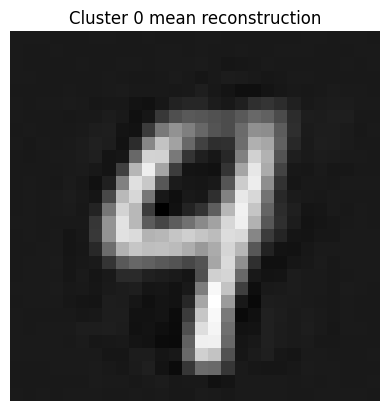

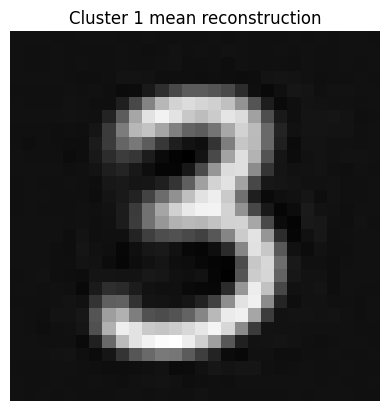

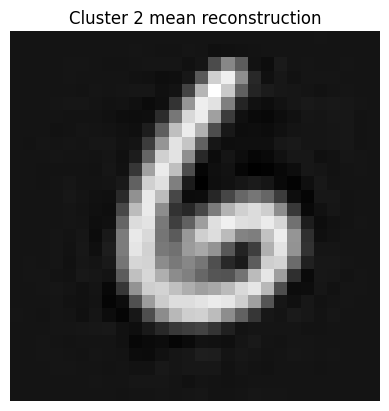

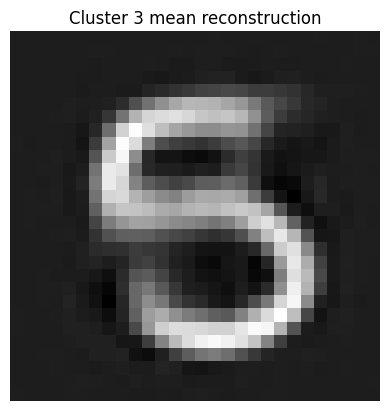

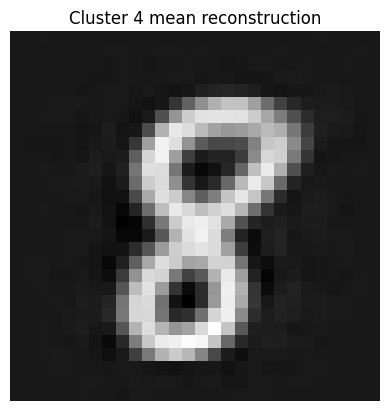

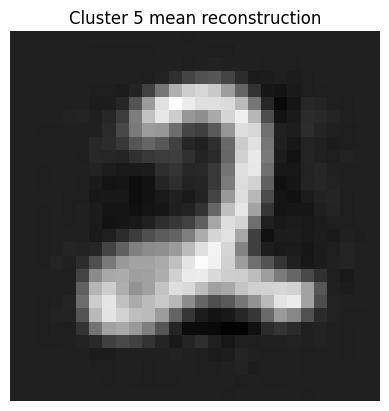

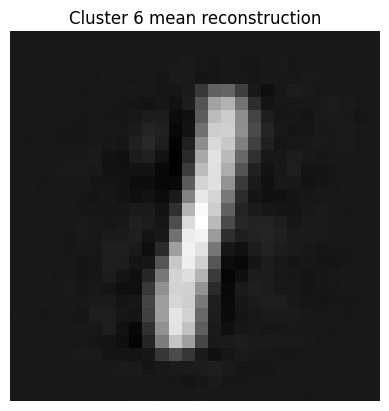

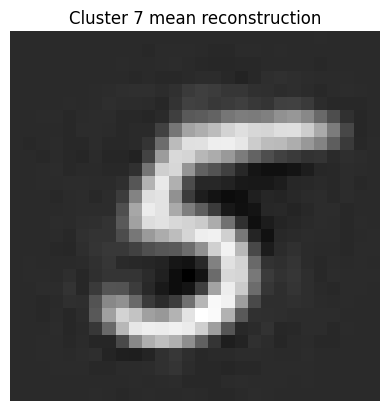

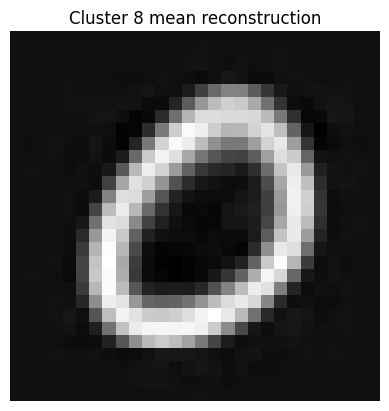

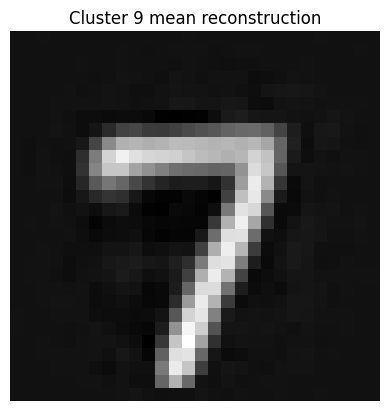

In [27]:
for k in range(10):
    mu_k = state.params['pgm']['loc'][k]
    z = mu_k.T.astype(jnp.float32)

    likelihood = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        z,
        method=SVAE_GMM.decode
    )

    recon_img = likelihood.mean()[0]
    plt.imshow(recon_img.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'Cluster {k} mean reconstruction')
    plt.show()

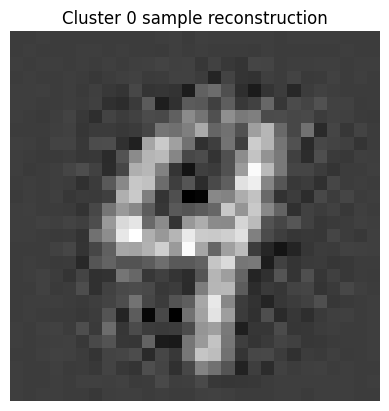

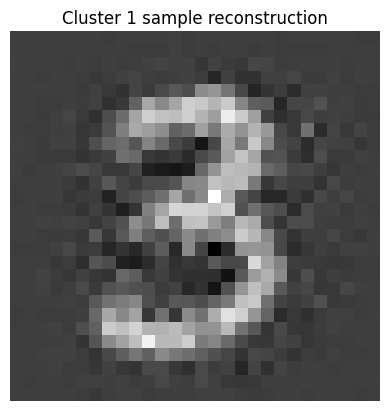

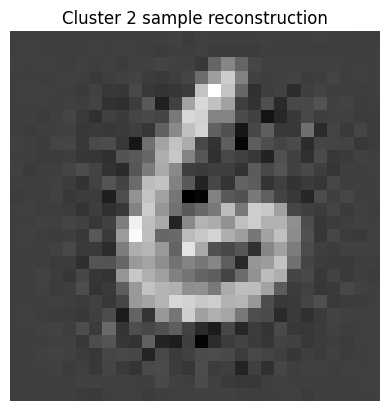

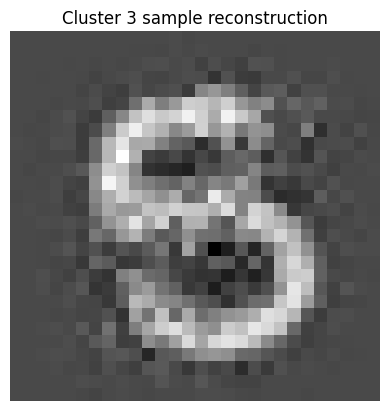

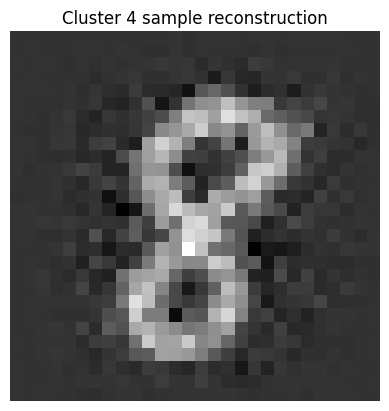

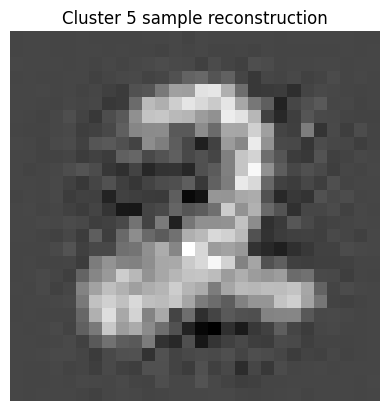

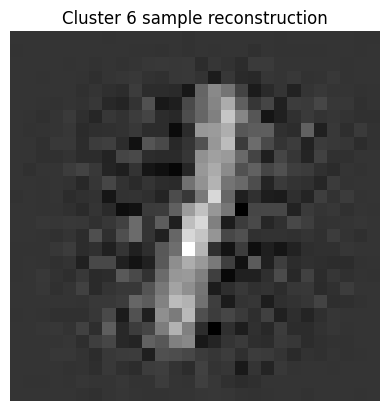

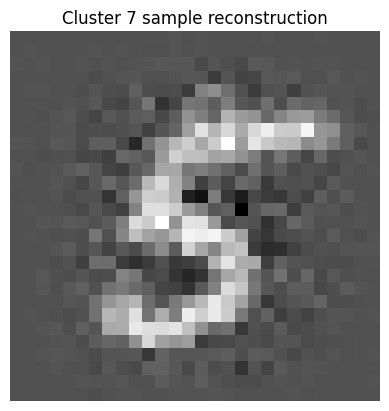

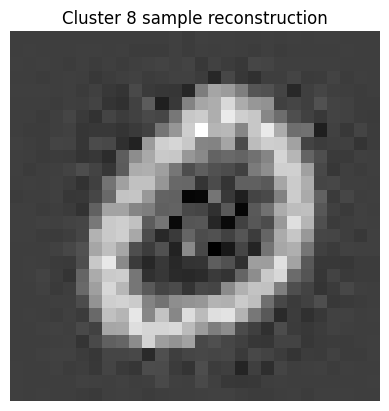

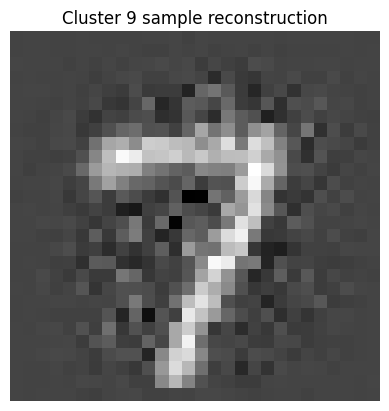

In [28]:
for k in range(10):
    mu_k = state.params['pgm']['loc'][k]
    z = mu_k.T.astype(jnp.float32)

    likelihood = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        z,
        method=SVAE_GMM.decode
    )

    recon_img = likelihood.sample(seed=jax.random.PRNGKey(47))
    plt.imshow(recon_img.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'Cluster {k} sample reconstruction')
    plt.show()

In [29]:
#Latent and cluster assignments
all_latents_train = []
all_clusters_train = []

for batch in train_loader_inference:
    batch = batch[0]
    batch_np = batch.detach().cpu().numpy()

    _, _, _, aux = eval_step(state, batch_np, N_data=len(train_loader_inference.dataset))
    
    z = aux['aux'][0] 
    c = aux['aux'][1]

    all_latents_train.append(z)
    all_clusters_train.append(jnp.argmax(c, axis=1))
    
all_latents_train_np = jnp.concatenate(all_latents_train, axis=0)
all_clusters_train_np = jnp.concatenate(all_clusters_train, axis=0)

In [30]:
acc = clustering_accuracy(true_labels_train, all_clusters_train_np)
print(f"Hungarian-matched Accuracy: {acc:.4f}")

Hungarian-matched Accuracy: 0.8276


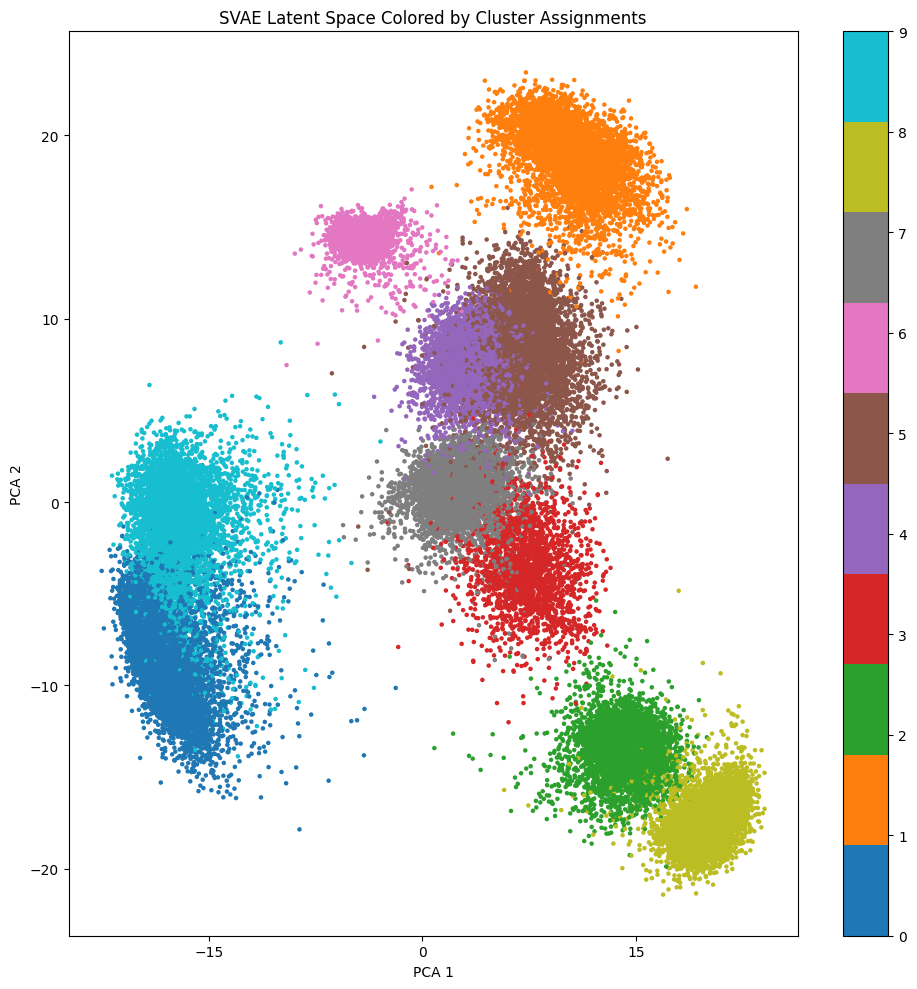

In [32]:
z_pca = PCA(n_components=2).fit_transform(all_latents_train_np)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=all_clusters_train_np, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title("SVAE Latent Space Colored by Cluster Assignments")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

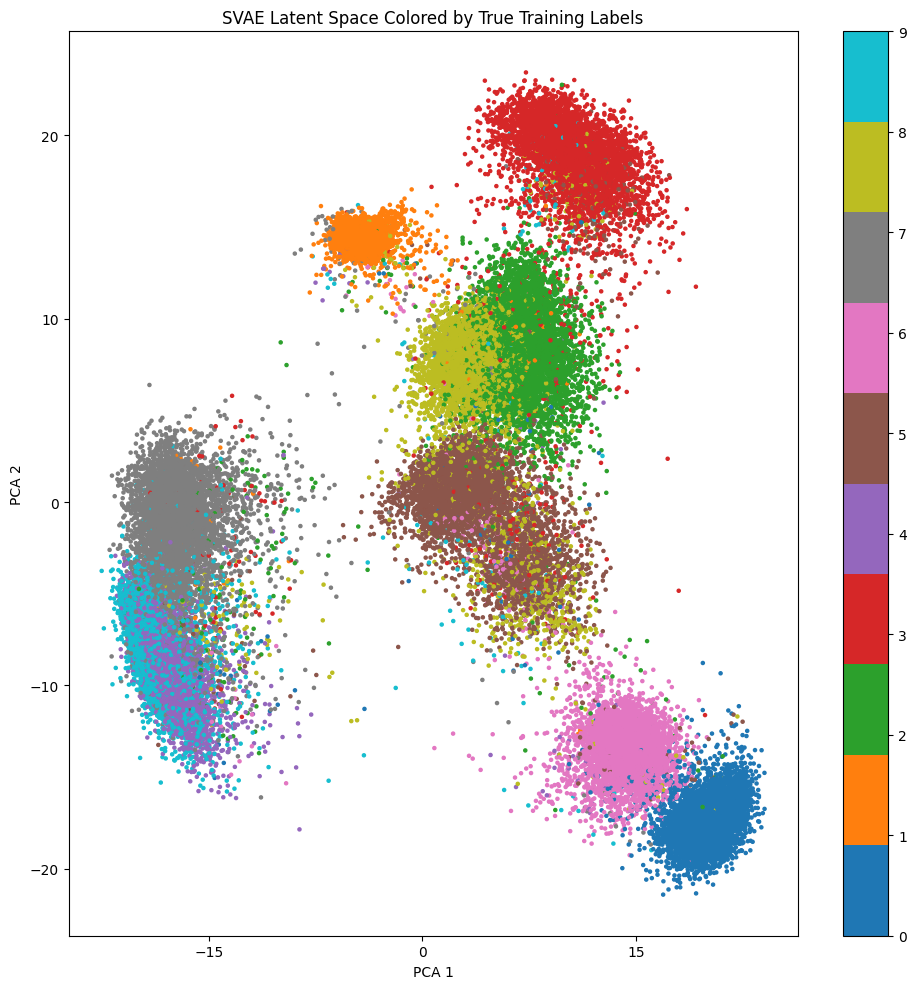

In [33]:
z_pca = PCA(n_components=2).fit_transform(all_latents_train_np)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(z_pca[:, 0], z_pca[:, 1], c=true_labels_train, cmap='tab10', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title("SVAE Latent Space Colored by True Training Labels")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

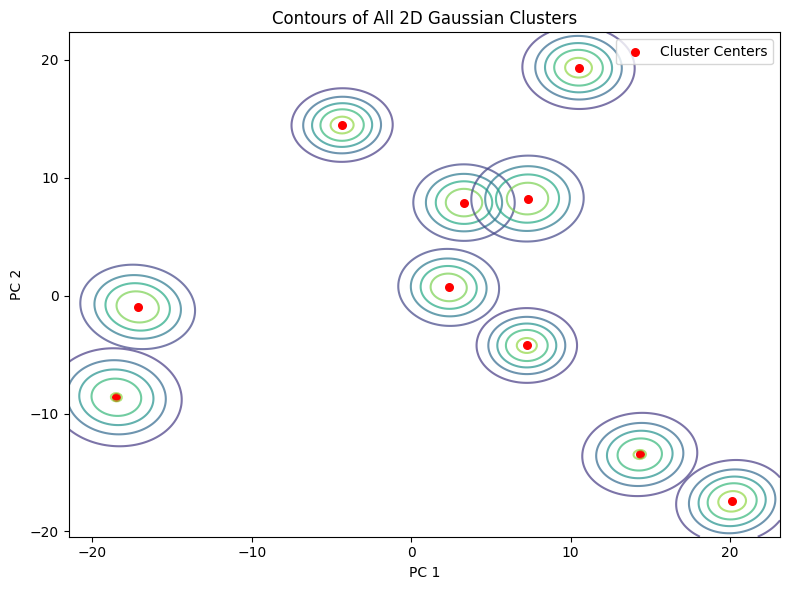

In [35]:
# Extract cluster parameters from your model
S = state.params['pgm']['S']         # shape: (K, D, D)
nu = state.params['pgm']['nu']       # shape: (K,)
loc = state.params['pgm']['loc']     # shape: (K, D)

# Convert from JAX to NumPy and squeeze
means = [np.array(loc[k]).squeeze() for k in range(len(loc))]
D = S.shape[-1]
covariances = [np.array(S[k]) for k in range(len(S))]

# Project to 2D using PCA (fit on means)
means_matrix = np.stack(means)  # shape: (K, D)
pca = PCA(n_components=2)
pca.fit(all_latents_train_np)
means_2d = pca.transform(means_matrix)

covariances_2d = []
P = pca.components_  # shape (2, 10)

for cov in covariances:
    cov_2d = P @ cov @ P.T  # shape (2, 2)
    covariances_2d.append(cov_2d)

covariances_2d = np.stack(covariances_2d)

# Combine all cluster means to find global plotting bounds
means_2d_array = np.array(means_2d)
x_min, x_max = means_2d_array[:, 0].min() - 3, means_2d_array[:, 0].max() + 3
y_min, y_max = means_2d_array[:, 1].min() - 3, means_2d_array[:, 1].max() + 3

# Shared grid
N = 300
x = np.linspace(x_min, x_max, N)
y = np.linspace(y_min, y_max, N)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Plot all clusters
fig, ax = plt.subplots(figsize=(8, 6))

for mean, cov in zip(means_2d, covariances_2d):
    rv = multivariate_normal(mean, cov)
    Z = rv.pdf(pos)
    ax.contour(X, Y, Z, levels=5, alpha=0.7)  # optionally: colors='tab10(i)', cmap=...

# Optionally add mean points
ax.scatter(means_2d_array[:, 0], means_2d_array[:, 1], color='red', s=30, label='Cluster Centers')
ax.set_title("Contours of All 2D Gaussian Clusters")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.legend()
plt.tight_layout()
plt.show()

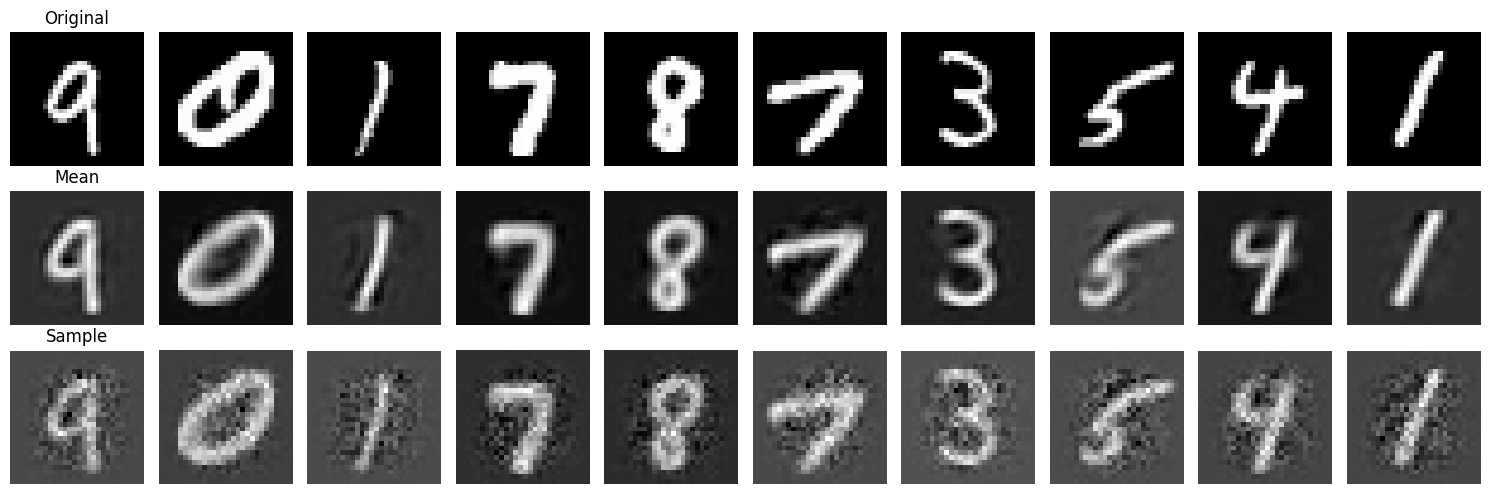

In [36]:
batch, _ = next(iter(train_loader))
batch = batch.numpy()
batch = jnp.array(batch)

_, _, likelihood, aux = eval_step(state, batch, N_data=60000)

recon_means = likelihood.mean()  
recon_samples = likelihood.sample(seed=jax.random.PRNGKey(0))

fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i in range(10):
    # Original
    axes[0, i].imshow(batch[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0: axes[0, i].set_title("Original")

    # Mean reconstruction
    axes[1, i].imshow(recon_means[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0: axes[1, i].set_title("Mean")

    # Sampled reconstruction
    axes[2, i].imshow(recon_samples[i].reshape(28, 28), cmap='gray')
    axes[2, i].axis('off')
    if i == 0: axes[2, i].set_title("Sample")

plt.tight_layout()
plt.show()